## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Calibrating camera...
Reprojection error: 1.186897


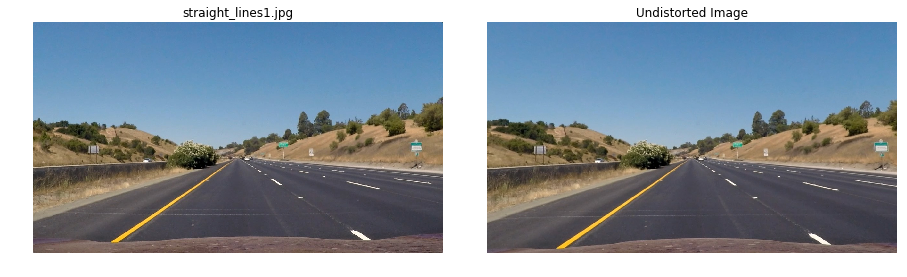

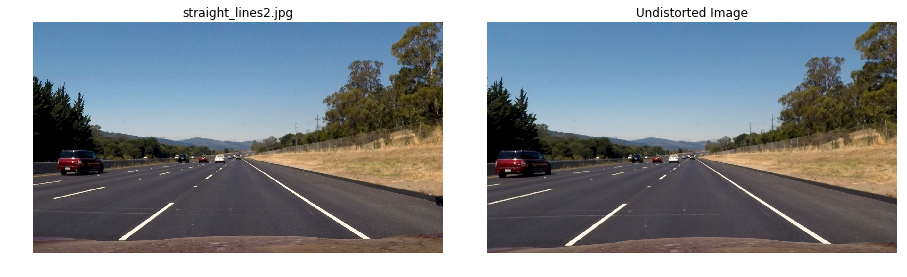

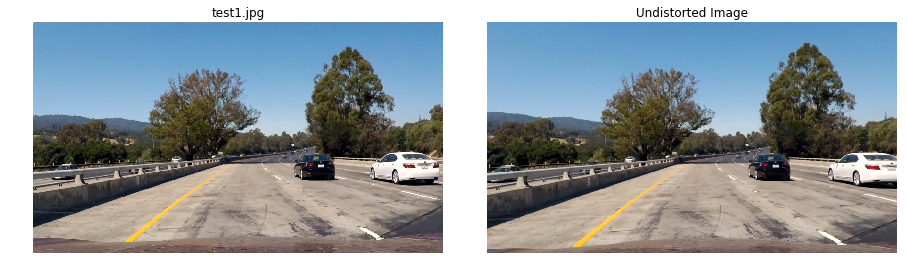

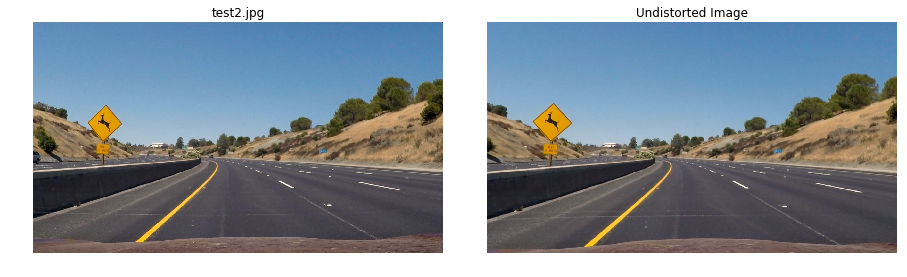

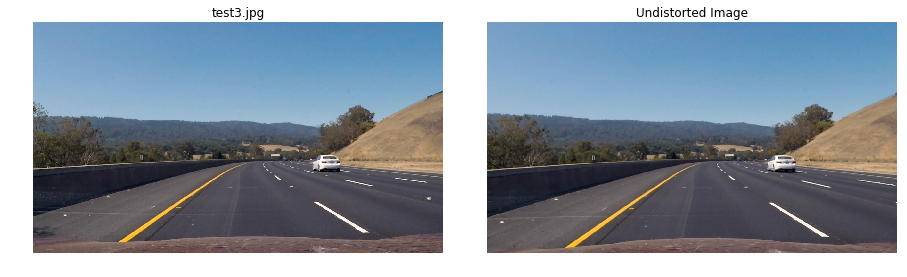

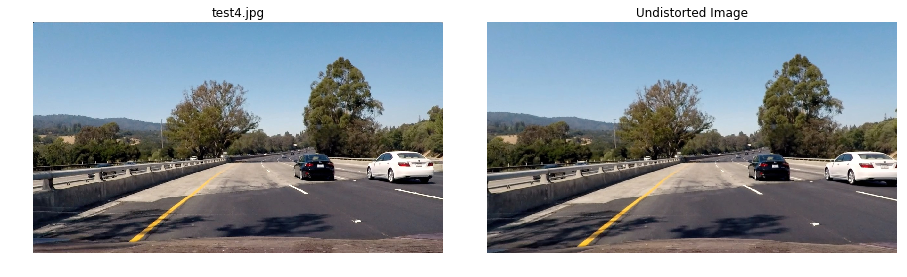

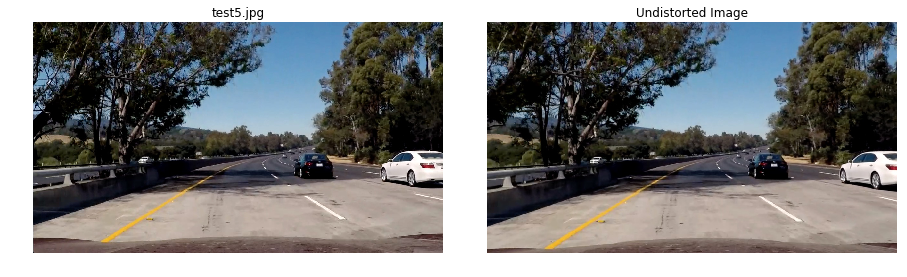

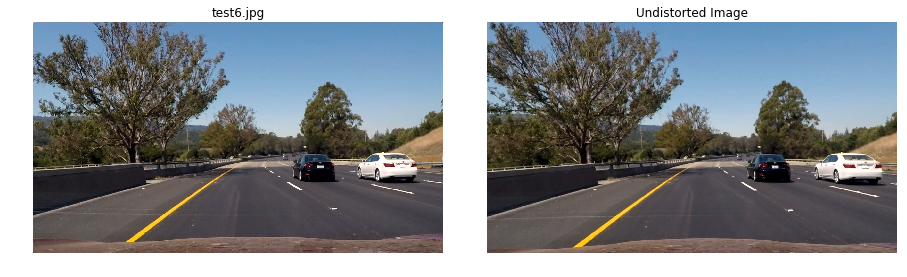

In [1]:
#importing some useful packages
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

IMAGE_SHAPE = (720,1280,3)

CAL_IMAGES_DIR = "camera_cal/"
TEST_IMAGES_DIR = "test_images/"

CAL_NX = 9 # the number of inside corners in x
CAL_NY = 6 # the number of inside corners in y

def calibrate_camera(imgdir, nx, ny):
    
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    for filename in os.listdir(imgdir):
        # Read in an image
        img = cv2.imread(imgdir + filename)
    
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    height, width, _ = IMAGE_SHAPE
    
    print("Calibrating camera...")
    error, mtx, coefs, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, (width, height) , None, None)
    print("Reprojection error: {:6f}".format(error))   
    
    return mtx, coefs

def undistort_image(img, mtx, dist):   
    return cv2.undistort(img, mtx, dist, None, mtx)

mtx, dist = calibrate_camera(CAL_IMAGES_DIR, CAL_NX, CAL_NY)

for filename in os.listdir(TEST_IMAGES_DIR):
    image = mpimg.imread(TEST_IMAGES_DIR + filename)
    undistorted = undistort_image(image, mtx, dist)    

    fig, ax = plt.subplots(1, 2, figsize=(12,16))
    fig.tight_layout()
    ax[0].imshow(image)
    ax[0].set_title(filename)
    ax[0].set_axis_off()
    ax[1].imshow(undistorted)
    ax[1].set_title('Undistorted Image')
    ax[1].set_axis_off()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
    plt.show()

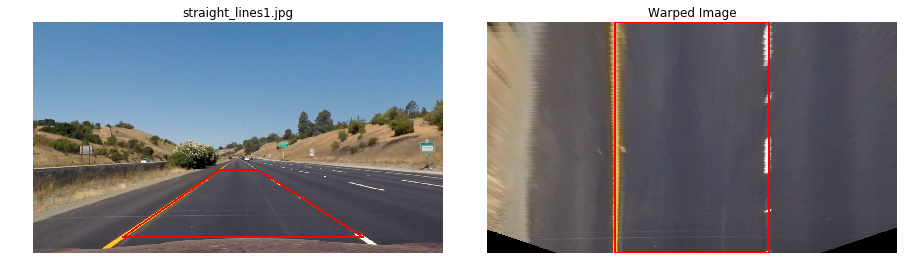

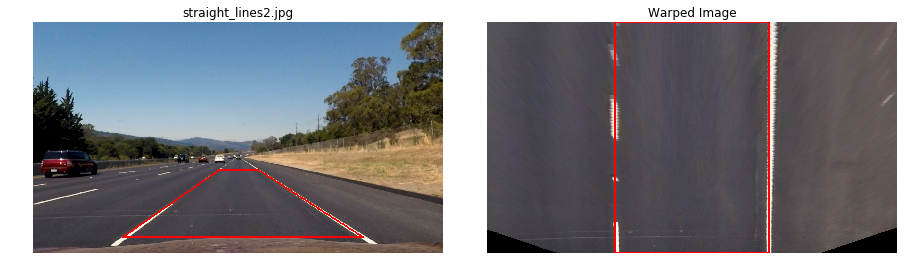

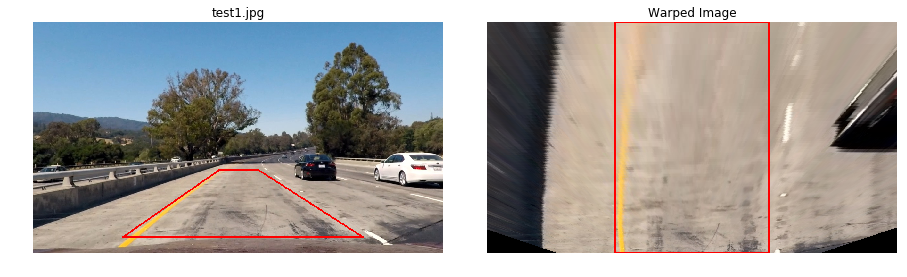

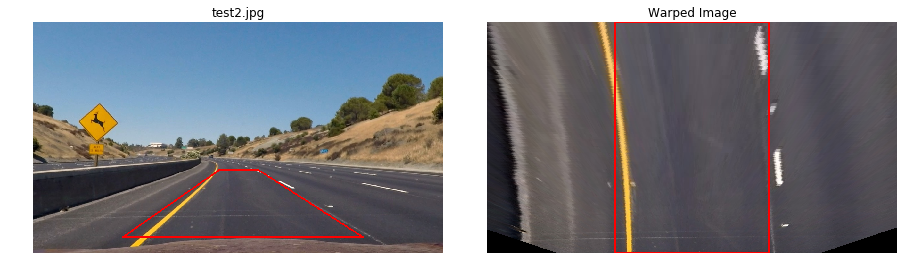

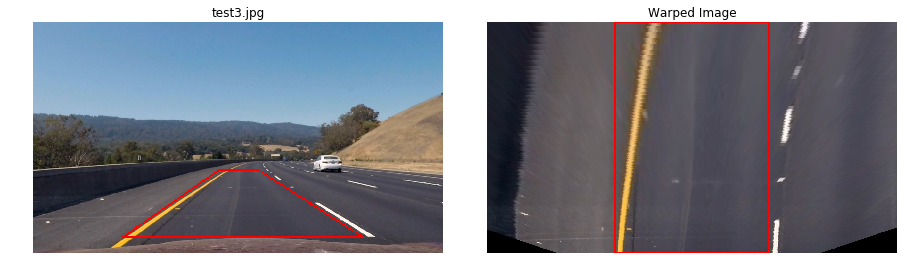

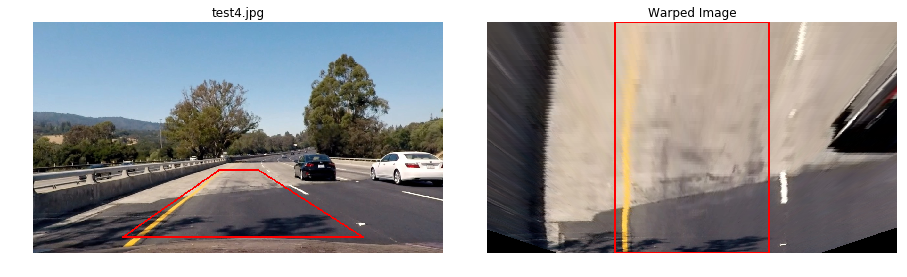

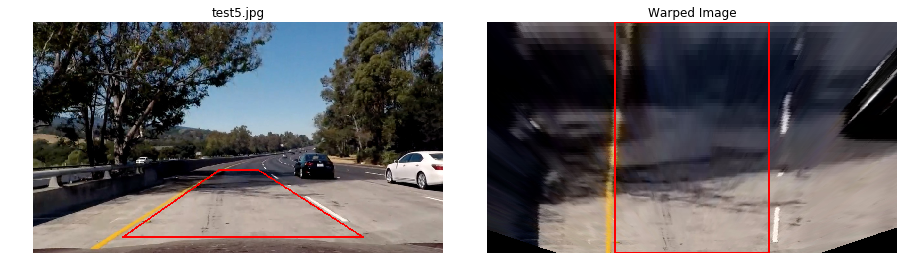

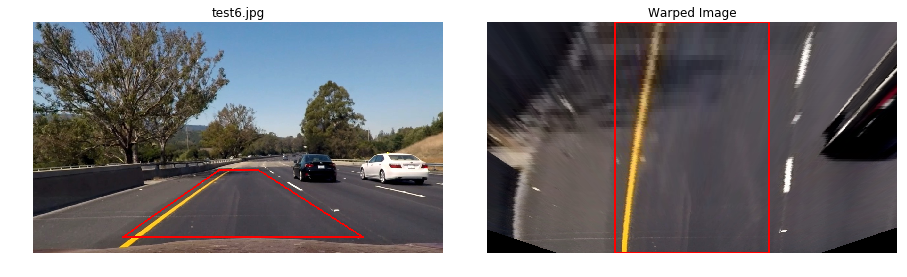

In [2]:
import pickle

from ipywidgets import interact_manual, fixed
import ipywidgets as widgets

region_params_file = "saved_data/region_params.p"

def get_vertices(region_params):
    
    height, width, _ = IMAGE_SHAPE
    
    apex_loff, apex_roff, apex_yoff, base_loff, base_roff, base_yoff, warp_xoff = region_params

    apex_left = (width / 2 - apex_loff, height / 2 + apex_yoff)
    apex_right =(width / 2 + apex_roff, height / 2 + apex_yoff)
    base_left = (base_loff, height - base_yoff)
    base_right = (width - base_roff, height - base_yoff)

    vertices = np.int32([base_left, apex_left, apex_right, base_right])
    warped_vertices = np.int32([[warp_xoff, height], [warp_xoff, 0], [width - warp_xoff, 0], [width - warp_xoff, height]])
    return vertices, warped_vertices
    
def warp_image(img, src, dst):
    M = cv2.getPerspectiveTransform(np.float32([src]), np.float32([dst]))
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_NEAREST+cv2.WARP_FILL_OUTLIERS)
    return warped

def region_interactor(apex_loff, apex_roff, apex_yoff, base_loff, base_roff, base_yoff, warp_xoff):
    
    region_params = [apex_loff, apex_roff, apex_yoff, base_loff, base_roff, base_yoff, warp_xoff]
    
    vertices, warped_vertices = get_vertices(region_params)

    pickle.dump(region_params, open(region_params_file, "wb" ) )
    
    for filename in os.listdir(TEST_IMAGES_DIR):
        image = mpimg.imread(TEST_IMAGES_DIR + filename)

        undistorted = undistort_image(image, mtx, dist)    

        warped = warp_image(undistorted, vertices, warped_vertices)

        cv2.polylines(undistorted, [vertices], 1, [255,0,0], 4)
        cv2.polylines(warped, [warped_vertices], 1, [255,0,0], 4)

        fig, ax = plt.subplots(1, 2, figsize=(12,16))
        fig.tight_layout()
        ax[0].imshow(undistorted)
        ax[0].set_title(filename)
        ax[0].set_axis_off()
        ax[1].imshow(warped)
        ax[1].set_title('Warped Image')
        ax[1].set_axis_off()
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
        plt.show()

region_params = []
with open(region_params_file, mode='rb') as f:
    region_params = pickle.load(f)

interact_manual(region_interactor, 
                apex_loff=widgets.IntSlider(min=0,max=100,step=1,value=region_params[0], description="Apex Left Offset"),                
                apex_roff=widgets.IntSlider(min=0,max=100,step=1,value=region_params[1], description="Apex Right Offset"),                
                apex_yoff=widgets.IntSlider(min=0,max=100,step=1,value=region_params[2], description="Apex Y Offset"),                
                base_loff=widgets.IntSlider(min=0,max=300,step=1,value=region_params[3], description="Base Left Offset"),                
                base_roff=widgets.IntSlider(min=0,max=300,step=1,value=region_params[4], description="Base Right Offset"),                
                base_yoff=widgets.IntSlider(min=0,max=100,step=1,value=region_params[5], description="Base Y Offset"),                
                warp_xoff=widgets.IntSlider(min=0,max=400,step=5,value=region_params[6], description="Warp X Offset"));

In [3]:
def sobel_threshold(img, mag_thresh, dir_thresh, x_thresh, y_thresh, kernel_size=5):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
    sobel_mag = np.hypot(sobel_x, sobel_y)
    sobel_mag = np.uint8(sobel_mag * 255 / np.max(sobel_mag))
    sobel_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    
    binary_output = np.zeros_like(gray)    
    binary_output[((sobel_mag >= mag_thresh[0]) & (sobel_mag <= mag_thresh[1]) &
                  (sobel_dir >= dir_thresh[0]) & (sobel_dir <= dir_thresh[1])) |
                  ((sobel_x >= x_thresh[0]) & (sobel_x <= x_thresh[1]) &
                  (sobel_y >= y_thresh[0]) & (sobel_y <= y_thresh[1]))] = 255
    
    return binary_output

def color_threshold(img, h_thresh, l_thresh, s_thresh, white_sens, yellow_sens):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    lower_thresh = np.array([h_thresh[0], l_thresh[0], s_thresh[0]])
    upper_thresh = np.array([h_thresh[1], l_thresh[1], s_thresh[1]])

    thresh_mask = cv2.inRange(hls, lower_thresh, upper_thresh)

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    lower_white = np.array([0, 0, 255-white_sens])
    upper_white = np.array([180, white_sens, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    lower_yellow = np.array([30 - yellow_sens, 100, 100]) 
    upper_yellow = np.array([30 + yellow_sens, 255, 255])    
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    return cv2.bitwise_or(thresh_mask, cv2.bitwise_or(white_mask, yellow_mask))

def find_lanes(warped, window_height, window_width, margin, l_center, r_center):
    height = warped.shape[0]
    width = warped.shape[1]    

    left_lane_points = [] # Store the (x,y) positions for the left lane
    right_lane_points = [] # Store the (x,y) positions for the right lane

    window = np.ones(window_width)
    # Build triangular window
    window[0:window_width // 2] = np.linspace(0, 1, window_width // 2, endpoint=False)
    window = np.flipud(window)
    window[0:window_width // 2] = np.linspace(0, 1, window_width // 2, endpoint=False)
    
    # Find the two starting positions for the left and right lane by taking a slice at the bottom of the image     
    l_sum = np.sum(warped[3 * height // 4:,l_center - margin:width // 2], axis=0)
    l_center = np.argmax(np.convolve(window, l_sum)) - window_width / 2 + (l_center - margin)
    
    r_sum = np.sum(warped[3 * height // 4:, width // 2:r_center + margin], axis=0)
    r_center = np.argmax(np.convolve(window, r_sum)) - window_width / 2 + width // 2
    
    # Add what we found for the first layer,
    #left_lane_points.append((l_center, height))
    #right_lane_points.append((r_center, height))
    
    # Go through each layer looking for max pixel locations
    for level in range(0, int(height / window_height)):
        # convolve the window into the vertical slice of the image
        y_min = height - (level + 1) * window_height
        y_max = height - level * window_height
        y_center = y_min + window_height / 2
        image_layer = np.sum(warped[y_min : y_max, :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width / 2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,width))
        if (np.sum(conv_signal[l_min_index:l_max_index]) != 0):
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,width))
        if (np.sum(conv_signal[r_min_index:r_max_index]) != 0):
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset

        # Add what we found for that layer
        left_lane_points.append((l_center, y_center))
        right_lane_points.append((r_center, y_center))

    return left_lane_points, right_lane_points

def get_radius(x_values, y_values, x_point):
    # Fit new polynomials to x,y in world space
    poly_q = np.polyfit(x_values, y_values, 2)
    return ((1 + (2*poly_q[0]*x_point + poly_q[1])**2)**1.5) / np.absolute(2*poly_q[0])

7026.54876994 m,  9661.51621635 m


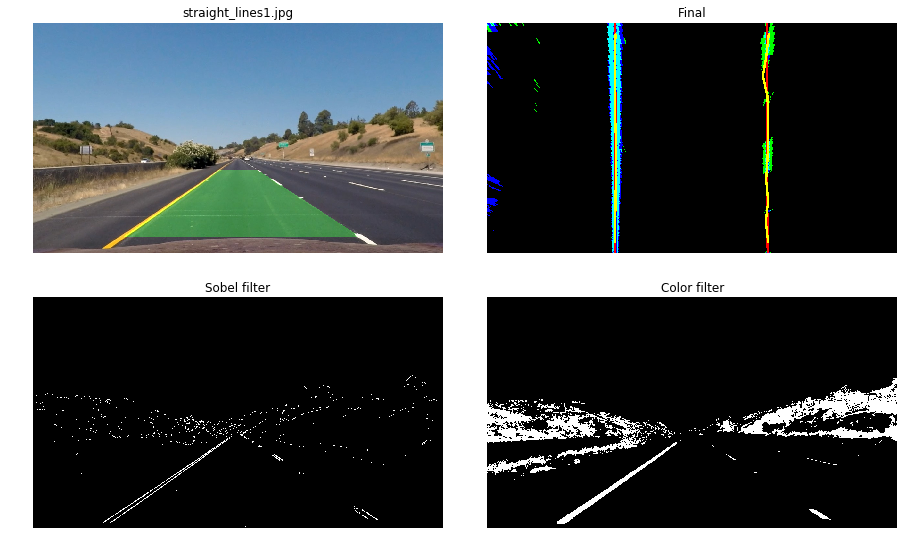

1160.77866892 m,  38646.6767914 m


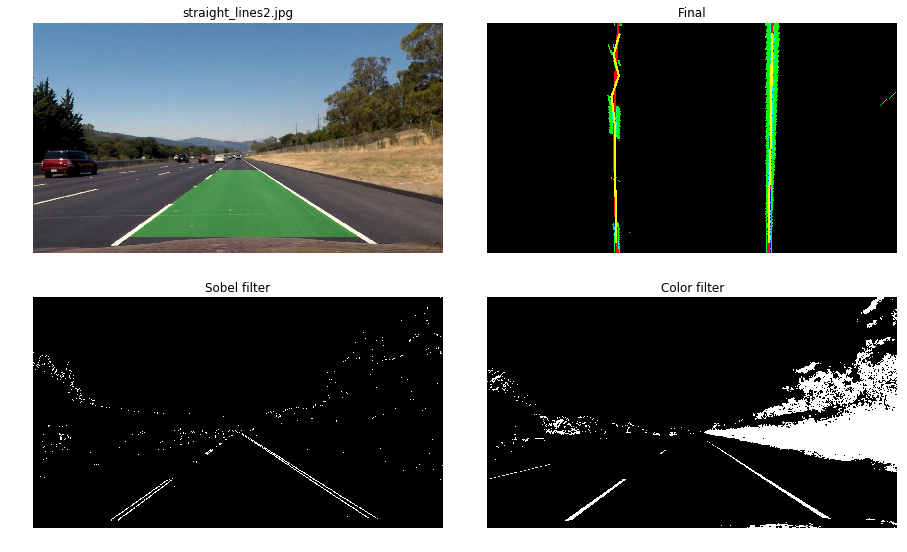

475.44940454 m,  2274.27243921 m


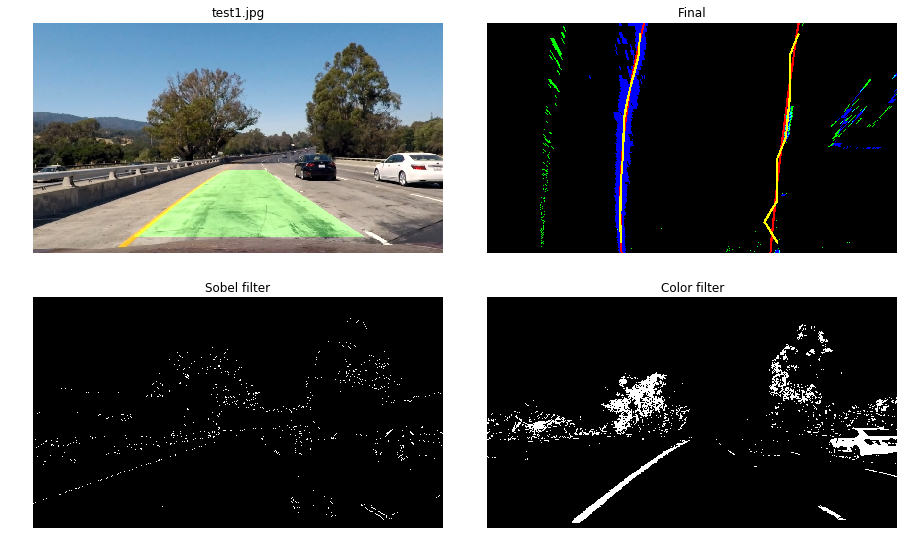

601.961100923 m,  360.070601625 m


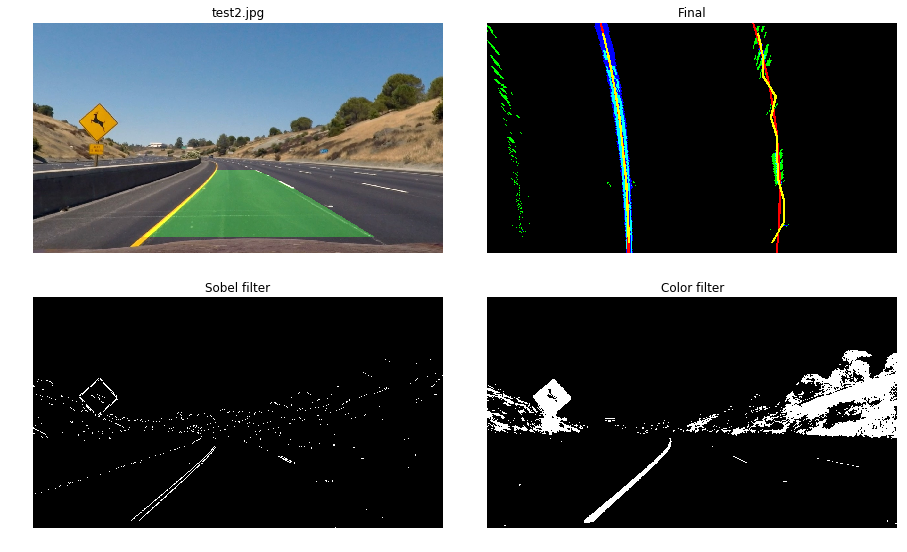

1185.89887067 m,  843.883626768 m


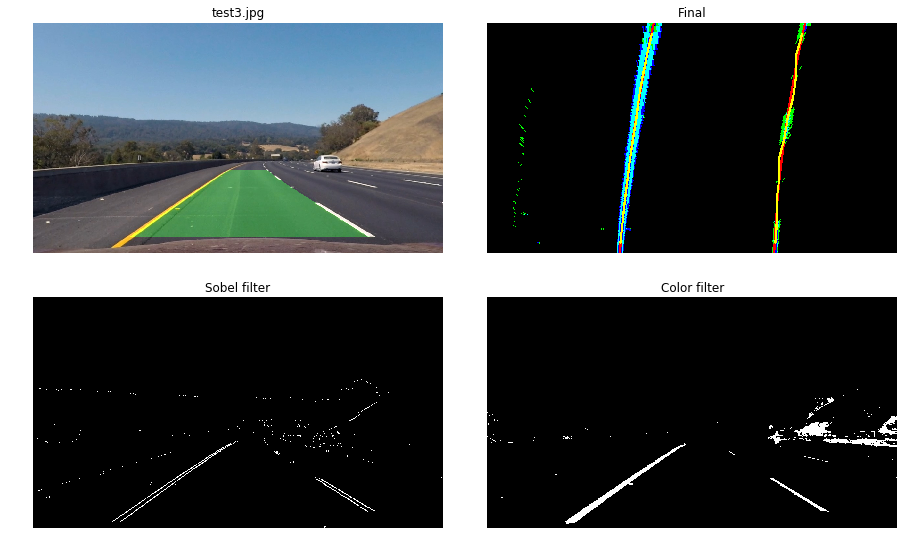

451.188090146 m,  220.619203322 m


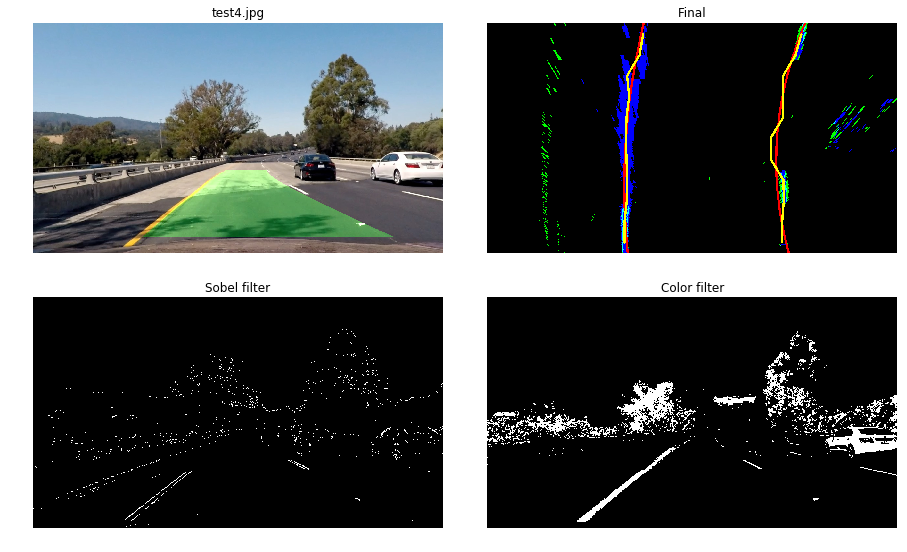

384.005239434 m,  2357.89399575 m


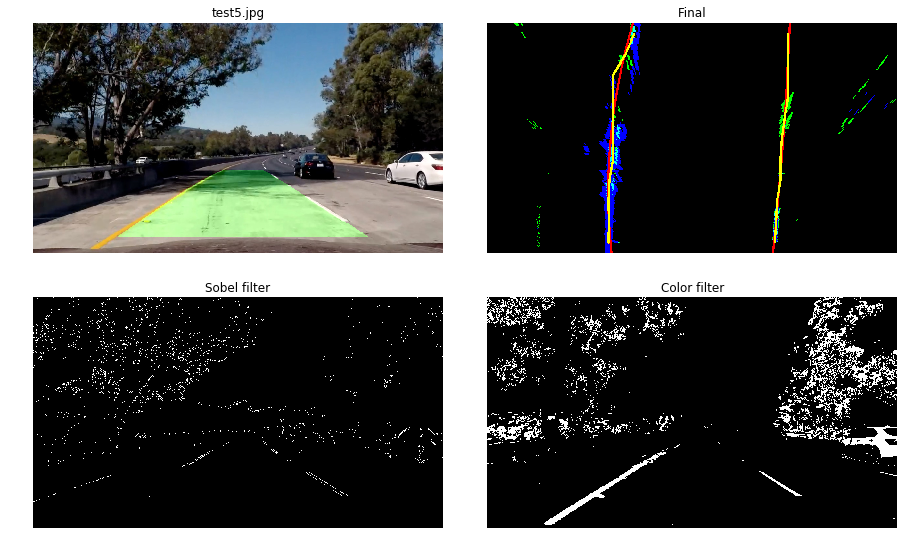

1790.31156467 m,  940.473345803 m


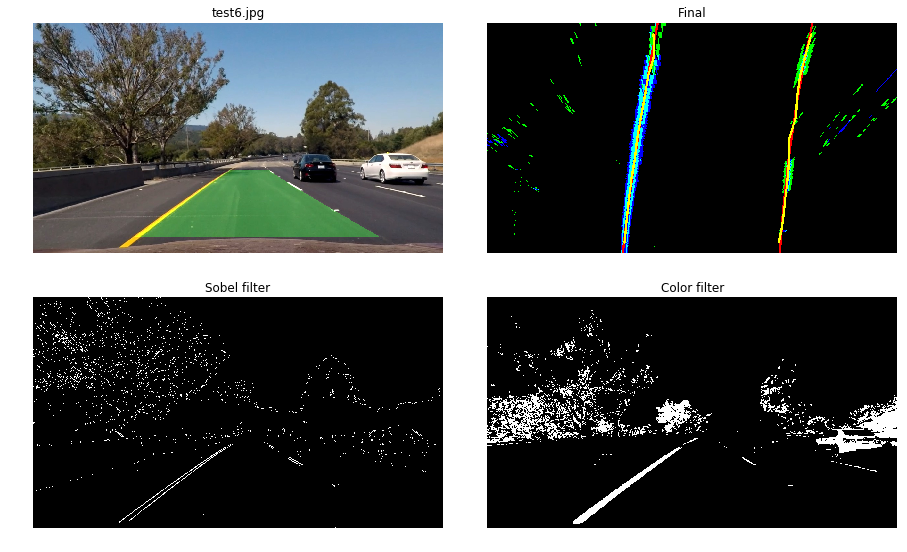

In [4]:
import pickle

from ipywidgets import interact_manual, fixed
import ipywidgets as widgets

filter_params_file = "saved_data/filter_params.p"

def filter_interactor(x_thresh, y_thresh, mag_thresh, dir_thresh, ksize, 
                      h_thresh, l_thresh, s_thresh, white_sens, yellow_sens, 
                      win_height, win_width, margin):

    filter_params = [x_thresh, y_thresh, mag_thresh, dir_thresh, ksize, 
                     h_thresh, l_thresh, s_thresh, white_sens, yellow_sens, 
                     win_height, win_width, margin]
    
    pickle.dump(filter_params, open(filter_params_file, "wb" ) )

    region_params = []
    with open(region_params_file, mode='rb') as f:
        region_params = pickle.load(f)

    m_per_pixel_x = 3.7 / (IMAGE_SHAPE[1] - 2 * region_params[-1])
    m_per_pixel_y = 3 / 74 # Using warped version of straight_lines2.jpg, we measure the left dash-line pixel size: 74 

    vertices, warped_vertices = get_vertices(region_params)
    l_center = warped_vertices[0,0]
    r_center = warped_vertices[-1,0]

    for filename in os.listdir(TEST_IMAGES_DIR):
        image = mpimg.imread(TEST_IMAGES_DIR + filename)
        undistorted = undistort_image(image, mtx, dist)

        binary_sobel = sobel_threshold(undistorted, mag_thresh, dir_thresh, x_thresh, y_thresh, ksize)
        binary_color = color_threshold(undistorted, h_thresh, l_thresh, s_thresh, white_sens, yellow_sens)

        binary_lanes = cv2.bitwise_or(binary_sobel, binary_color)
        warped_lanes = warp_image(binary_lanes, vertices, warped_vertices)

        left_lane, right_lane = find_lanes(warped_lanes, win_height, win_width, margin, l_center, r_center)
    
        left_lane = np.asarray(left_lane)
        right_lane = np.asarray(right_lane)
       
        yp = np.linspace(0, image.shape[0] - 1, num=image.shape[0])
        lpoly_q = np.polyfit(left_lane[:,1], left_lane[:,0], 2)
        leftxp = np.poly1d(lpoly_q)(yp)
        rpoly_q = np.polyfit(right_lane[:,1], right_lane[:,0], 2)
        rightxp = np.poly1d(rpoly_q)(yp)
        
        cleaned = np.dstack((np.zeros_like(binary_lanes), binary_sobel, binary_color))

        cleaned = warp_image(cleaned, vertices, warped_vertices)

        leftp = np.int32(np.dstack((leftxp, yp)))
        rightp = np.int32(np.dstack((rightxp, yp)))
        
        cv2.polylines(cleaned, leftp, 0, [255,0,0], 6)  
        cv2.polylines(cleaned, rightp, 0, [255,0,0], 6)
        
        cv2.polylines(cleaned, np.expand_dims(np.int32(left_lane), axis=0), 0, [255, 255, 0], 6)
        cv2.polylines(cleaned, np.expand_dims(np.int32(right_lane), axis=0), 0, [255, 255, 0], 6)

        # Create an image to draw the lines on
        road_image = np.zeros_like(image).astype(np.uint8)

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts = np.hstack((leftp[:,::-1], rightp))
                
        # Draw the lane onto the warped blank image
        cv2.fillPoly(road_image, pts, (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        road_image = warp_image(road_image, warped_vertices, vertices) 
        # Combine the result with the original image
        undistorted = cv2.addWeighted(undistorted, 1, road_image, 0.3, 0)
        
        left_rad = get_radius(left_lane[:,1] * m_per_pixel_y, 
                              left_lane[:,0] * m_per_pixel_x, 
                              IMAGE_SHAPE[0] * m_per_pixel_y)
        right_rad = get_radius(right_lane[:,1] * m_per_pixel_y, 
                               right_lane[:,0] * m_per_pixel_x, 
                               IMAGE_SHAPE[0] * m_per_pixel_y)
        
        print(left_rad, 'm, ', right_rad, 'm')

        fig, ax = plt.subplots(2, 2, figsize=(12,8))
        fig.tight_layout()
        ax[0][0].imshow(undistorted)
        ax[0][0].set_title(filename)
        ax[0][0].set_axis_off()
        ax[0][1].imshow(cleaned)
        ax[0][1].set_title('Final')
        ax[0][1].set_axis_off()
        ax[1][0].imshow(binary_sobel, cmap='gray')
        ax[1][0].set_title('Sobel filter')
        ax[1][0].set_axis_off()
        ax[1][1].imshow(binary_color, cmap='gray')
        ax[1][1].set_title('Color filter')
        ax[1][1].set_axis_off()
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)    
        plt.show()


filter_params = []
with open(filter_params_file, mode='rb') as f:
    filter_params = pickle.load(f)

#filter_params = [(200,255), (200,255), (50,250), (0.0, np.pi/2), 3, (200,255), (200,255), (200,255), 15, 15, 60, 60, 60]

interact_manual(filter_interactor, 
                x_thresh=widgets.IntRangeSlider(min=0,max=255,step=5,value=filter_params[0], description="Sobel X"), 
                y_thresh=widgets.IntRangeSlider(min=0,max=255,step=5,value=filter_params[1], description="Sobel Y"), 
                mag_thresh=widgets.IntRangeSlider(min=0,max=255,step=5,value=filter_params[2], description="Sobel Magnitud"), 
                dir_thresh=widgets.FloatRangeSlider(min=0.0,max=np.pi/2,step=0.1,value=filter_params[3], description="Sobel Direction"),
                ksize=widgets.IntSlider(min=1,max=9,step=2,value=filter_params[4], description="Kernel Size"),                
                h_thresh=widgets.IntRangeSlider(min=0,max=255,step=5,value=filter_params[5], description="Hue"), 
                l_thresh=widgets.IntRangeSlider(min=0,max=255,step=5,value=filter_params[6], description="Lightness"), 
                s_thresh=widgets.IntRangeSlider(min=0,max=255,step=5,value=filter_params[7], description="Saturation"), 
                white_sens=widgets.IntSlider(min=0,max=50,step=1,value=filter_params[8], description="White Sensitivity"), 
                yellow_sens=widgets.IntSlider(min=0,max=50,step=1,value=filter_params[9], description="Yellow Sensitivity"), 
                win_height=widgets.IntSlider(min=0,max=200,step=5,value=filter_params[10], description="Window Y"),
                win_width=widgets.IntSlider(min=0,max=200,step=5,value=filter_params[11], description="Window X"),
                margin=widgets.IntSlider(min=0,max=200,step=5,value=filter_params[12], description="Window margin"));

In [5]:
region_params = []
with open(region_params_file, mode='rb') as f:
    region_params = pickle.load(f)

m_per_pixel_x = 3.7 / (IMAGE_SHAPE[1] - 2 * region_params[-1])
m_per_pixel_y = 3 / 74 # Using warped version of straight_lines2.jpg, we measure the left dash-line pixel size: 74 

vertices, warped_vertices = get_vertices(region_params)

l_center = warped_vertices[0,0]
r_center = warped_vertices[-1,0]

filter_params = []
with open(filter_params_file, mode='rb') as f:
    filter_params = pickle.load(f)

x_thresh, y_thresh, mag_thresh, dir_thresh, ksize, \
h_thresh, l_thresh, s_thresh, white_sens, yellow_sens, \
win_height, win_width, margin = filter_params

#onetime = 0

def process_image(image):
#    global onetime
#    if (onetime == 0):
#        onetime = 1
#        mpimg.imsave("harder_images/harder1.jpg", image)
             
    undistorted = undistort_image(image, mtx, dist)

    binary_sobel = sobel_threshold(undistorted, mag_thresh, dir_thresh, x_thresh, y_thresh, ksize)
    binary_color = color_threshold(undistorted, h_thresh, l_thresh, s_thresh, white_sens, yellow_sens)

    binary_lanes = cv2.bitwise_or(binary_sobel, binary_color)
    warped_lanes = warp_image(binary_lanes, vertices, warped_vertices)

    left_lane, right_lane = find_lanes(warped_lanes, win_height, win_width, margin, l_center, r_center)

    left_lane = np.asarray(left_lane)
    right_lane = np.asarray(right_lane)

    yp = np.linspace(0, image.shape[0] - 1, num=image.shape[0])
    leftxp = np.poly1d(np.polyfit(left_lane[:,1], left_lane[:,0], 2))(yp)
    rightxp = np.poly1d(np.polyfit(right_lane[:,1], right_lane[:,0], 2))(yp)

    leftp = np.int32(np.dstack((leftxp, yp)))
    rightp = np.int32(np.dstack((rightxp, yp)))

    # Create an image to draw the lines on
    road_image = np.zeros_like(image).astype(np.uint8)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(road_image, np.hstack((leftp[:,::-1], rightp)), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    road_image = warp_image(road_image, warped_vertices, vertices) 
    # Combine the result with the original image
    undistorted = cv2.addWeighted(undistorted, 1, road_image, 0.3, 0)

    left_rad = get_radius(left_lane[:,1] * m_per_pixel_y, 
                          left_lane[:,0] * m_per_pixel_x, 
                          IMAGE_SHAPE[0] * m_per_pixel_y)
    right_rad = get_radius(right_lane[:,1] * m_per_pixel_y, 
                           right_lane[:,0] * m_per_pixel_x, 
                           IMAGE_SHAPE[0] * m_per_pixel_y)
    
    cv2.putText(undistorted, "{}".format(left_rad), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0))
    return undistorted



In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

filenames = [("project_video.mp4", "easy.mp4"), 
             ("challenge_video.mp4", "hard.mp4"),
             ("harder_challenge_video.mp4", "harder.mp4")]

#filenames = [("harder_challenge_video.mp4", "harder.mp4")]


for infile, outfile in filenames:
    clip = VideoFileClip(infile)
    clip_processed = clip.fl_image(process_image)
    %time clip_processed.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video easy.mp4
[MoviePy] Writing video easy.mp4


100%|█████████▉| 1260/1261 [02:44<00:00,  7.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: easy.mp4 

CPU times: user 2min 49s, sys: 22 s, total: 3min 11s
Wall time: 2min 45s
[MoviePy] >>>> Building video hard.mp4
[MoviePy] Writing video hard.mp4


100%|██████████| 485/485 [01:03<00:00,  7.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: hard.mp4 

CPU times: user 1min 6s, sys: 8.53 s, total: 1min 15s
Wall time: 1min 4s
[MoviePy] >>>> Building video harder.mp4
[MoviePy] Writing video harder.mp4


100%|█████████▉| 1199/1200 [02:42<00:00,  7.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder.mp4 

CPU times: user 2min 47s, sys: 21.5 s, total: 3min 9s
Wall time: 2min 43s


In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
<video width="960" height="540" controls>
  <source src="{1}">
</video>
<video width="960" height="540" controls>
  <source src="{2}">
</video>
""".format(filenames[0][1], filenames[1][1], filenames[2][1]))